### Zhangs method

For this task, we use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. We have familiarised ourselves with the different parameters for this method.

In [6]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

In [4]:
three_D_object_points = [] 
img_points = []

checker_board = (6, 8) 
termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

object_point = np.zeros((checker_board[0]*checker_board[1], 3), np.float32)
object_point[:,:2] = np.mgrid[0:checker_board[0], 0:checker_board[1]].T.reshape(-1, 2)

images = glob.glob('./Images/Zhangs/*.JPG')

for image in images:
    checkboard_img = cv2.imread(image)
    checkboard_gray_img = cv2.cvtColor(checkboard_img, cv2.COLOR_BGR2GRAY)
    
    ret_mat, corners = cv2.findChessboardCorners(checkboard_gray_img, checker_board, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret_mat:
        corners_d = cv2.cornerSubPix(checkboard_gray_img, corners, (11,11), (-1,-1), termination_criteria)
        img_points.append(corners_d)
        three_D_object_points.append(object_point)
        img = cv2.resize(cv2.drawChessboardCorners(checkboard_img, checker_board, corners_d, ret_mat), (960, 640))
        cv2.imshow(image, img)
        cv2.waitKey(1000)

cv2.destroyAllWindows()

ret_mat, camera_mat, dist, rvecs, tvecs = cv2.calibrateCamera(three_D_object_points, img_points, checkboard_gray_img.shape[::-1], None, None)
print("Camera matrix:" ,camera_mat)

Camera matrix: [[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


total error:  0.3192637458104168


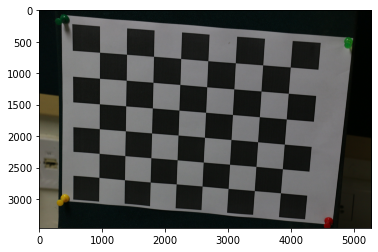

In [7]:
img = cv2.imread('./Images/Zhangs/IMG_5464.JPG')
newcameramtx, roi =cv2.getOptimalNewCameraMatrix(camera_mat,dist,(img.shape[:2][1],img.shape[:2][0]),1,(img.shape[:2][1],img.shape[:2][0]))

dst_img = cv2.undistort(img, camera_mat, dist, None, newcameramtx)
x,y,w,h = roi
dst_img = dst_img[y:y+h, x:x+w]
dst_img = cv2.cvtColor(dst_img,cv2.COLOR_BGR2RGB)
plt.imshow(dst_img)

tot_error = 0
for i in range(len(three_D_object_points)):
    img_points2, _ = cv2.projectPoints(three_D_object_points[i], rvecs[i], tvecs[i], camera_mat, dist)
    tot_error +=  cv2.norm(img_points[i],img_points2, cv2.NORM_L2)/len(img_points2)
avg_err = tot_error/len(three_D_object_points)
print ("total error: ",avg_err)

This is Zhangs method for camera calibration. 

There are notable differences between this method of camera calibration when compared to the DLT method.

## Estimation
The DLT estimates the camera intrinsics as well as the extrinsics, this is a total of 5 + 6 = 11 parameters. Zhang's method estimates just the intrinsics of the camera by a homogenous matrix with just 8 degrees of freedom.

## Point properties
The DLT needs at least 6 2D-3D correspondances. All these points MUST NOT lie on a plane. Zhang's method requires that all the four points from an image lie on the same plane (that of the checker board)

## Frames
The DLT just needs 1 view where all the 3D points are described with respect to the world frame. Zhang's method required 3 different views of a plane (that of the checker board) each with its own coordinate frame chosen such that all the 3D world points lie on the same plane.